In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import reshape_as_image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from sklearn.model_selection import train_test_split
import glob,os,sys,cv2
from datetime import datetime
import visualkeras
from PIL import ImageFont
import wandb
from wandb.keras import WandbCallback

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.chdir("/home/jovyan/MSC_Thesis/MSc_Thesis_2023")
training_path = "Input/sentinel/test_data_from_drive/patches_all/all_states_normalised_b2_b8_b11/train"
target_file_path = "Input/Target/concat/target_yield.shp"
patch_dim = (256, 256, 4)
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
# mape = tf.keras.metrics.MeanAbsolutePercentageError()
msle = tf.keras.metrics.MeanSquaredLogarithmicError()

metrics = {'segmentation':[tf.keras.metrics.BinaryIoU(target_class_ids = (0, 1),
                            threshold=0.5,
                            name=None,
                            dtype=None),
           tf.keras.metrics.BinaryAccuracy(
                            name='binary_accuracy', dtype=None, threshold=0.5
                        )],
           'reg_output':[mse,mae,msle]}



config = {
"epochs":15,
"batch_size":64,
"loss_function":{'segmentation': 'binary_crossentropy', 'reg_output': 'mse'},
# "metrics":[mse,rmse,mae,mape,msle,cos_sim,log_cos],
"metrics":metrics,
"learning_rate":1e-4
# "optimizer":'adam'
}

2023-11-12 12:43:16.117858: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
def read_training():
    training_file_list = glob.glob(os.path.join(training_path,"*.tif"))
    target_gdf = gpd.read_file(target_file_path)
    print("Total Number of Patches:",len(training_file_list))
    ignore_patch_list = list()
    x = list()
    y = list()
    y_reg = list()
    X_train = list()
    X_test = list()
    y_train = list()
    y_train_reg = list()
    y_test = list()
    y_test_reg = list()
    count = 0 
    for file in training_file_list:

        patch_src = rio.open(file)
        f_name = file.split("/")[-1].split(".")[0]
        patch_src_read = reshape_as_image(patch_src.read()) ## Change the index here to add or remove the mask layer
        # print(0)
        if patch_src_read.shape != patch_dim:
            ignore_patch_list.append(f_name)
            # print("Patch Dimensions Mismatch, skipping patch : {}".format(f_name))
            continue

        # print(1)
        if np.isnan(patch_src_read).any():
            # print("Has Nan values, skipping patch : {}".format(f_name))
            continue
        if np.unique(patch_src_read[:,:,3],return_counts=True)[1][1] < 655:
            # Skipping patch since less than 1% of patch is covered by Soybean
            # Not ideal for segmentation
            continue
        # print(2)
        query = target_gdf.query(f"patch_name == '{f_name}'")["ykg_by_e7"]
        if len(query) != 1:
            # print("patch has no target value, skipping patch : {}".format(f_name))
            continue
        x.append(patch_src_read[:,:,0:3])
        y.append(patch_src_read[:,:,3])
        y_reg.append(float(query))
        patch_src.close()
        # print(count)
        count +=1
        if count > 1000:
            break

    # self.y = self.scaler.fit_transform(np.array(self.y).reshape(-1, 1))
    y = np.array(y)
    y = np.expand_dims(y,-1)
    y_reg = np.expand_dims(y_reg,-1)
    x = np.array(x)
    
    # x = (x-np.min(x))/(np.max(x)-np.min(x))
    print("Any Null values? ",np.isnan(x).any())
    # print(self.y)
    # self.x = np.nan_to_num(self.x, nan=0)# Check for different value for no data
    print(f"x shape :{x.shape}, y shape: {y.shape}, y_reg shape : {y_reg.shape}")
    # print(np.nanmin(self.x),np.nanmax(self.x))
    X_train, X_test, y_train, y_test,y_reg_train,y_reg_test = train_test_split(x, y, y_reg,test_size=0.25)
    return X_train, X_test, y_train, y_test,y_reg_train,y_reg_test
    #Also, split the training into train and val
    # For testing, keep a part of the dataset as seperate (final month)

In [3]:
X_train, X_test, y_train, y_test,y_reg_train,y_reg_test = read_training()
# unet_model = models.load_model(model_path, compile=True)

Total Number of Patches: 12361
Any Null values?  False
x shape :(1001, 256, 256, 3), y shape: (1001, 256, 256, 1), y_reg shape : (1001, 1)


In [59]:
def generate_data(x, y,y_reg, batch_size = 32):
    num_examples = len(y)
    num_of_batches = math.ceil(num_examples/batch_size)
    j = 0
    while True:
    # for j in range(num_of_batches):
        
        start_index = j*batch_size
        j+=1
        
        end_index = start_index+batch_size
        if end_index > num_examples:
            end_index = num_examples
        
        b_size = end_index - start_index
        if b_size <= 0:
            j = 0
            break
        x_batch = np.zeros((b_size, 256, 256, 3))
        y_batch = np.zeros((b_size,256,256,1))
        reg_batch = np.zeros((b_size,))
        
                
        for i in range(0, batch_size):
            # index = np.random.randint(0, num_examples)
            if start_index >= num_examples:
                break
            image, mask, r_yield = x[start_index], y[start_index], y_reg[start_index]
            start_index+=1
            x_batch[i] = image
            y_batch[i] = mask
            reg_batch[i] = r_yield

        yield x_batch, [y_batch, reg_batch]

In [60]:
train_dataset = generate_data(X_train,y_train,y_reg_train,batch_size=config["batch_size"])
validation_dataset = generate_data(X_test,y_test,y_reg_test,batch_size=config["batch_size"])

In [40]:
train_dataset = np.array(list(train_dataset))

/tmp/ipykernel_459/1438576359.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_dataset = np.array(list(train_dataset))


In [19]:
import math
math.ceil(len(y_train)/64)

12

In [41]:
train_dataset.shape

(12, 2)

In [66]:
a = list()
for i in train_dataset:
    a.append(i)
    print(i[0].shape)

In [12]:
len(a)

0

In [13]:
a[1][0].shape

IndexError: list index out of range

In [161]:
i[1][0].shape

(46, 256, 256, 1)

In [169]:
i[1][1][0]

1.901368760965291

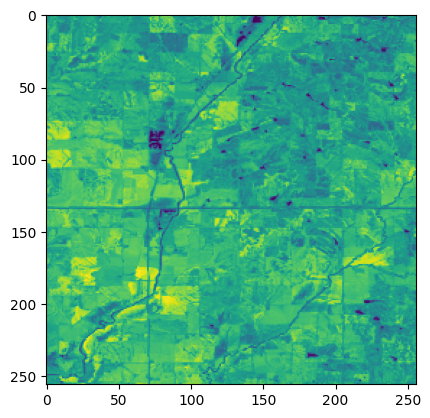

In [180]:
plt.imshow(a[1][0][1][:,:,1])

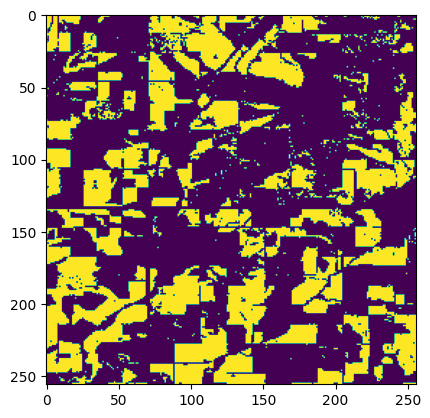

In [181]:
plt.imshow(a[1][1][0][1])

In [11]:
x,[y,y_r] = next(generate_data(X_train,y_train,y_reg_train,batch_size=config["batch_size"]))

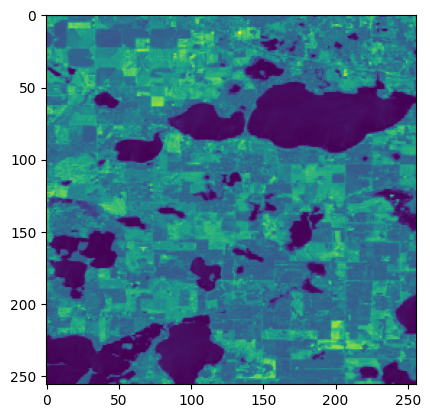

In [37]:
plt.imshow(x[6,:,:,2])

In [60]:
np.unique(y[10],return_counts=True)

(array([0., 1.]), array([62566,  2970]))

In [65]:
(2/100)*65534

1310.68

In [58]:
for i in range
np.unique(y[0],return_counts=True)[1][1] > 6550

False

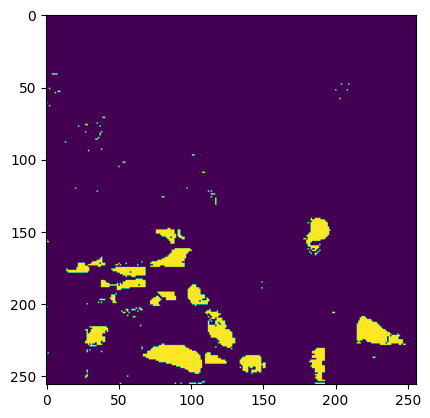

In [61]:
plt.imshow(y[10,:,:,0])